In [1]:
from scholte import *
k_obs,f_obs=load_dispersion_observations()

In [2]:
h0 =  [0.100, 0.005, 0.010, 0.02, 0.02, 0.02, 0.02, 0.0]
vs0 = [0.0233, 0.0522, 0.0906, 0.125 , 0.20 , 0.25, 1.5]

In [5]:
do_mcmc_8param(k_obs,f_obs, h0, vs0, N = 100, 
                filename='three-modes.pickle', 
                step_size = 2e-3,
                f_sensitivity = 0.01,
                verbose=False)

100%|██████████| 100/100 [00:04<00:00, 21.75it/s]

Runtime was 4.687662708000005
Acceptances = 39, Acceptance Ratio = 0.39


In [31]:
import pickle
x = pickle.load(open('three-modes.pickle', 'rb'))
n = x.shape[0]
y = x[int(n/3):,:]
ymean = np.mean(y,axis=0)

In [25]:
len(h0)

8

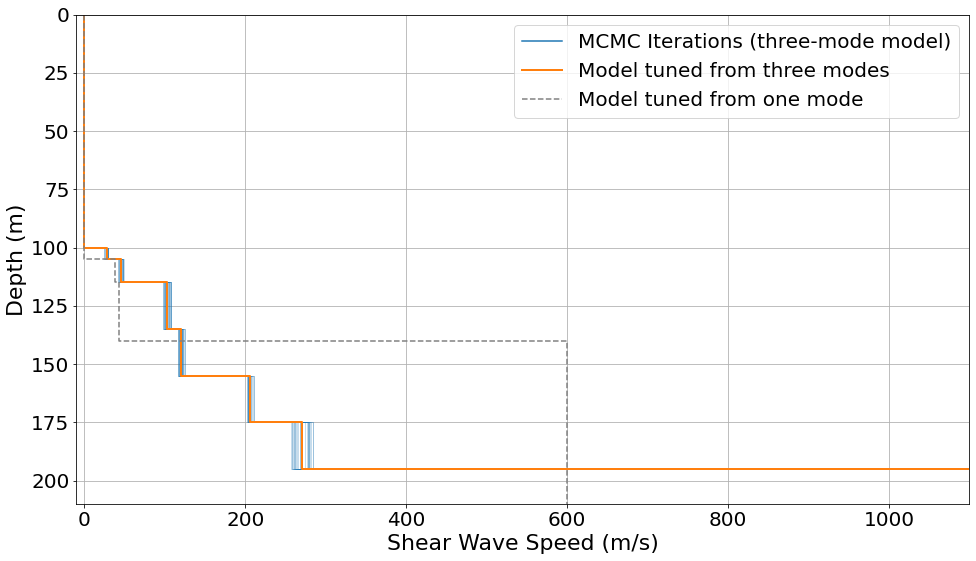

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 



fig,ax=plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('w')
plt.plot(0,0,label='MCMC Iterations (three-mode model)')
for xx in y:
    plt.step(np.hstack([0,xx,xx[-1]]), 
             np.hstack([0,np.cumsum(h0)*1000]),
             c='C0',alpha=0.5,linewidth=0.5)
    
plt.step(np.hstack([0,ymean,ymean[-1]]), 
         np.hstack([0,np.cumsum(h0)*1000]),
         c='C1',linewidth=2,label='Model tuned from three modes')

# One-mode tuned model
# h1 =  np.hstack([0,np.array([0.100, 0.005, 0.010, 0.025, 0.0])*1000,300])
# v1 = [0,0, 0.038, 0.043, 0.080, 0.600,0.6]

plt.step(np.array(v1)*1000, 
         np.cumsum(h1),
         '--',c='Grey',label='Model tuned from one mode')

plt.ylim([210,0])
plt.xlim([-10,1100])
plt.legend(fontsize=20)
plt.grid()
plt.ylabel('Depth (m)',fontsize=22)
plt.xlabel('Shear Wave Speed (m/s)',fontsize=22)
plt.show()

In [ ]:
y_mean = np.mean(y[:,8:],axis=0)
y_std  = np.std(y[:,8:],axis=0)
percent_change_from_initial_guess = (y_mean/1e3 - vs0)/vs0*100
percent_change_from_initial_guess

In [ ]:
np.round(y_mean/1000,4)

In [ ]:
fig,ax=plt.subplots()
fig.patch.set_facecolor('w')


def weighted_average(x):
    weighted_avg = 0
    thickness = 0

    n = 6
    for i in range(n):
        weighted_avg = weighted_avg + x[:,8+i]*x[:,1+i]
        thickness = thickness + x[0,1+i]
    return weighted_avg / thickness

wavg = weighted_average(x)
plt.plot( wavg ) 

m = []
s = []
for i in range(x[:,8].shape[0]):
    m.append( np.mean(wavg[0:i]))
    v = 0
    for j in range(8,15):
        v = np.var(wavg[0:i]) + v
    s.append(np.sqrt(v))
m = np.array(m)
s = np.array(s)
plt.plot(m)
plt.plot(m+s)
plt.plot(m-s)